In [1]:
import os
import numpy as np
from sklearn.decomposition import NMF
from sonnmf.main import sonnmf
from sonnmf.old.main import sonnmf as sonnmf_old
import matplotlib.pyplot as plt


In [2]:
def sample_dirichlet(alpha, N):
    k = len(alpha)
    theta = np.zeros((N, k))
    scale = 1
    for i in range(k):
        theta[:, i] = np.random.gamma(alpha[i], scale, N)
    S = np.sum(theta, axis=1)
    theta = theta / np.tile(S.reshape(-1, 1), (1, k))
    return theta


def create_synthetic_data():
    Wt = np.array([[1, 0, 0, 1], [1, 0, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1]])
    r = 4

    n = 500
    purity = 0.8
    alpha = 0.05 * np.ones((r, 1))
    Ht = sample_dirichlet(alpha, n).T
    for j in range(n):
        while np.max(Ht[:, j]) > purity:
            Ht[:, j: j+1] = sample_dirichlet(alpha, 1).T
    epsilon = 0.01
    Xt = np.dot(Wt, Ht)
    X = np.maximum(0, Xt + epsilon * np.random.randn(*Xt.shape))
    return X, Wt, Ht


def plot_3d(X, Wt, W, filepath=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0, :], X[1, :], X[2, :], c='lightblue', marker='o')
    ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='red', marker='o', s=144)
    ax.scatter(W[0, :], W[1, :], W[2, :], c='black', marker='x', s=144)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.legend(['Data points', 'True W', 'Estimated W'])
    ax.grid(True)
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath)
    else:
        plt.show()

def save_results(filepath, W, H, fscores, gscores, hscores, total_scores):
    with open(filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['hscores'], data['total_scores']

In [3]:
data_filepath = '../datasets/synthetic_data.npz'
ini_filepath = '../saved_models/synthetic/r{}_ini.npz'

In [4]:
if os.path.exists(data_filepath):
    data = np.load(data_filepath)
    M = data['M']
    W_true = data['W_true']
    H_true = data['H_true']
else:
    M, W_true, H_true = create_synthetic_data()
    with open(data_filepath, 'wb') as fout:
        np.savez_compressed(fout, M=M, W_true=W_true, H_true=H_true)

In [5]:
m, n = M.shape
max_iters = 100
r = 8

if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [6]:
save_filepath = '../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'
image_filepath = '../images/synthetic/r{}_l{}_g{}_it{}.jpg'


In [7]:
%%time 

W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=1e-6, gamma=1.5, itermax=max_iters, W_update_iters=10, early_stop=False, verbose=False)
# save_results(save_filepath.format(r, 0.001, 0.1, max_iters), W, H, fscores, gscores, hscores, total_scores)

CPU times: user 520 ms, sys: 3.14 ms, total: 524 ms
Wall time: 523 ms


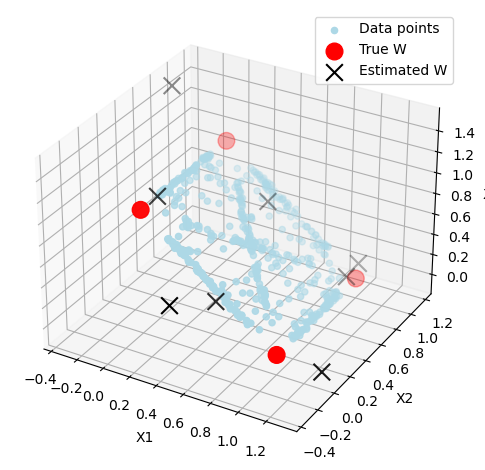

In [8]:
plot_3d(M, W_true, W)

In [11]:
%%time 

W, H, fscores, gscores, total_scores = sonnmf_old(M, ini_W.copy(), ini_H.copy(), lam=1e-6, w_update_method='admm', itermax=max_iters, W_update_iters=10, early_stop=False, verbose=False)
# save_results(save_filepath.format(r, 0.001, 0.1, max_iters), W, H, fscores, gscores, hscores, total_scores)

CPU times: user 2min 2s, sys: 654 ms, total: 2min 2s
Wall time: 2min 3s


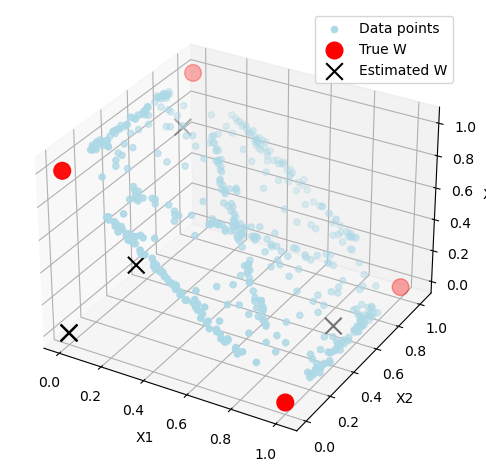

In [10]:
plot_3d(M, W_true, W)